In [27]:
import os
import time

import dill
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from chirho.dynamical.handlers import (LogTrajectory, StaticBatchObservation,
                                       StaticIntervention)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate
from chirho.observational.handlers import condition
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoMultivariateNormal

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from collab.foraging import locust as lc
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root, progress_saver

In [2]:
smoke_test = "CI" in os.environ
subset_starts = 1  # 420
subset_ends = 30 if smoke_test else 900
desired_frames = 50 if smoke_test else 250
num_iterations = 50 if smoke_test else 2000
num_samples = 20 if smoke_test else 500
num_steps = 10 if smoke_test else 100
sample_size = 100 if smoke_test else 1000
locust_sample_size = 100 if smoke_test else 178770
root = find_repo_root()


notebook_starts = time.time()

In [3]:
locust_data_path = os.path.join(root, "data/foraging/locust/15EQ20191202_tracked.csv")

df = lc.load_and_clean_locust(
    path=locust_data_path,
    desired_frames=desired_frames,
    grid_size=100,
    rewards_x=[0.68074, -0.69292],
    rewards_y=[-0.03068, -0.03068],
    subset_starts=subset_starts,
    subset_ends=subset_ends,
)

loc_subset = df["subset"]
loc_all = df["all_frames"]

original_frames: 45000
original_shape: (675000, 4)
resulting_frames: 250
resulting_shape: (3750, 4)
min_time 1
max_time 250
frames diff 899
desired_frames 250


In [4]:
object = loc_subset
rewards = object.rewardsDF.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True)
df = object.foragersDF
start, end, N_obs = min(df["time"]), max(df["time"]), len(df["time"].unique())

print(start, end, N_obs)

1 250 250


In [5]:
ft.animate_foragers(
    loc_subset,
    plot_rewards=True,
    height=600,
    point_size=10,
)

x     y  time  forager     state
0  69.0  91.0     1        1  search_r
1  19.0  52.0     1        2    feed_l
2  90.0  61.0     1        3  search_r
3  51.0  97.0     1        4    edge_r
4  40.0  88.0     1        5  search_l

   x  y     state  time  forager
0  0  0    edge_l     0        0
1  0  0    edge_r     0        0
2  0  0    feed_l     0        0
3  0  0    feed_r     0        0
4  0  0  search_l     0        0
5  0  0  search_r     0        0


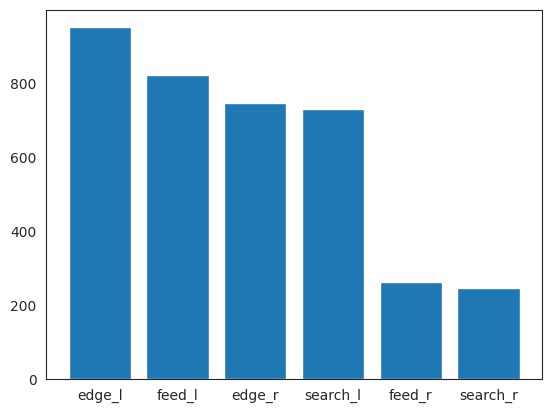

In [6]:
left_idx = rewards["x"].idxmin()
right_idx = rewards["x"].idxmax()
x_left = rewards.iloc[left_idx, 0]
y_left = rewards.iloc[left_idx, 1]

x_right = rewards.iloc[right_idx, 0]
y_right = rewards.iloc[right_idx, 1]

x_center = 50
y_center = 50


df_cat = ft.add_ring(
    df, "feed_l", x0=x_left, y0=y_left, outside_radius=10, inside_radius=0
)


df_cat = ft.add_ring(
    df_cat, "feed_r", x0=x_right, y0=y_right, outside_radius=10, inside_radius=0
)

df_cat = ft.add_ring(
    df_cat,
    "edge",
    x0=x_center,
    y0=y_center,
    outside_radius=51,
    inside_radius=47,
    divide_by_side=True,
)

df_cat = ft.add_ring(
    df_cat,
    "search",
    x0=x_center,
    y0=y_center,
    outside_radius=50,
    inside_radius=0,
    divide_by_side=True,
)


df_cat.drop(["type"], inplace=True, axis=1)

unique_states = set(df_cat["state"])


# these will be added to ensure the animation starts with
# all states represented
# ignore the initial frame in the animation
initial_fake_positions = pd.DataFrame(
    {
        "x": np.zeros(len(unique_states), dtype=int),
        "y": np.zeros(len(unique_states), dtype=int),
        "state": sorted(list(unique_states)),
        "time": [(start - 1)] * len(unique_states),
        "forager": np.zeros(len(unique_states), dtype=int),
    }
)

display(df_cat.head())

print(initial_fake_positions)

plt.bar(df_cat["state"].value_counts().index, df_cat["state"].value_counts())

df_cat_vis = pd.concat([initial_fake_positions, df_cat])
object.foragersDF = df_cat_vis

In [7]:
ft.animate_foragers(
    loc_subset,
    # loc_all,
    plot_rewards=True,
    height=600,
    point_size=10,
    color_by_state=True,
)

In [28]:
all_states = df_cat["state"].unique()
times = sorted(df_cat["time"].unique())
all_combinations = pd.DataFrame(
    [(state, time) for state in all_states for time in times],
    columns=["state", "time"],
)
counts = pd.merge(
    all_combinations,
    df_cat.groupby(["state", "time"]).size().reset_index(name="count"),
    how="left",
    on=["state", "time"],
)
counts["count"].fillna(0, inplace=True)

count_data = {}
for state in unique_states:
    count_data[f"{state}_obs"] = torch.tensor(
        counts[counts["state"] == state]["count"].values
    )

shapes = [tensor.shape for tensor in count_data.values()]
assert all(shape == shapes[0] for shape in shapes)


tensor_length = len(next(iter(count_data.values())))

assert N_obs == tensor_length, "Tensor length does not match number of observations!"

sums_per_position = [
    sum(count_data[state][k] for state in count_data) for k in range(tensor_length)
]
assert all(
    sums_per_position[0] == sum_at_k for sum_at_k in sums_per_position[1:]
), "Population count is not constant!"

init_state = {key[:-4]: count_data[key][0] for key in count_data.keys()}

print(init_state)

locust_count_data = {"count_data": count_data, "init_state": init_state}
locust_count_data_path = os.path.join(
    root, "data/foraging/locust/ds/locust_counts15EQ20191202.pkl"
)
with open(locust_count_data_path, "wb") as f:
    dill.dump(locust_count_data, f)

{'edge_r': tensor(6., dtype=torch.float64), 'edge_l': tensor(0., dtype=torch.float64), 'search_r': tensor(6., dtype=torch.float64), 'feed_r': tensor(0., dtype=torch.float64), 'search_l': tensor(2., dtype=torch.float64), 'feed_l': tensor(1., dtype=torch.float64)}


In [29]:
def moving_average(data, window_size):
    cumsum = torch.cumsum(data, dim=0)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1 :] / window_size


def plot_trajectories(
    data,
    times,
    window_size,
    title="Counts",
    scatter_data=None,
    scatter_data_type=None,
    observed=False,
):
    keys = ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"]
    observed_keys = [f"{key}_obs" for key in keys]
    colors = ["green", "darkgreen", "red", "darkred", "orange", "darkorange"]

    used_keys = observed_keys if observed else keys
    for state, color in zip(used_keys, colors):
        if window_size == 0:
            sns.lineplot(x=times, y=data[state], label=f"{state}", color=color)
            plt.title(title)
        else:
            running_averages = {
                state: moving_average(data[state].float(), window_size)
                for state in data
            }
            sns.lineplot(
                x=times[window_size - 1 :],
                y=running_averages[state],
                label=f"{state} (avg)",
                color=color,
            )
            plt.title(f"{title} (running average, window size = {window_size})")

    if scatter_data is not None:
        for state, color in zip(observed_keys, colors):
            sns.scatterplot(
                x=times,
                y=scatter_data[state],
                label=f"{state} - {scatter_data_type}",
                color=color,
            )

        # plt.xlim(start, end)
    plt.xlabel("time (frames)")
    plt.ylabel("# of locust")
    plt.legend(loc="upper right", fontsize="x-small")
    sns.despine()

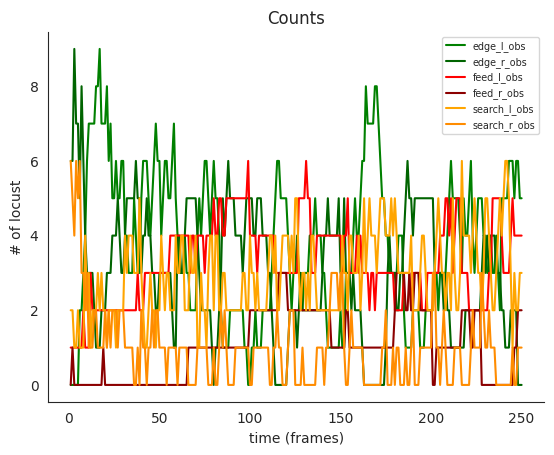

In [30]:
plot_trajectories(count_data, times, window_size=0, observed=True)

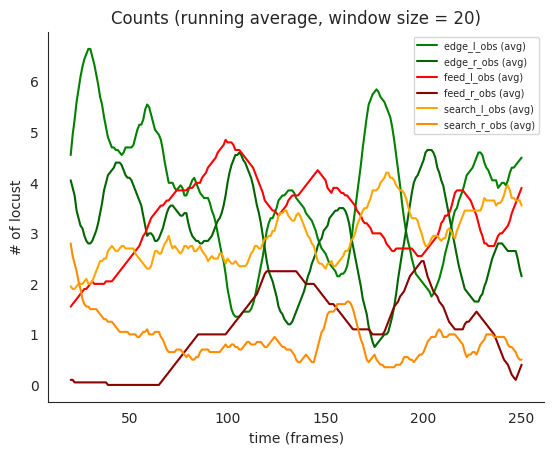

In [31]:
plot_trajectories(count_data, times, window_size=20, observed=True)

# note consider ending before they stop being hungry?

In [12]:
class LocustDynamics(pyro.nn.PyroModule):
    def __init__(self, attraction, wander):
        super().__init__()
        self.attraction = attraction
        self.wander = wander

    def forward(self, X: State[torch.Tensor]):
        dX = dict()
        w_ee, w_es, w_se, w_sf, w_fs, w_ss = torch.unbind(self.wander)
        a_eler, a_erel, a_es, a_se, a_ef, a_sf, a_fs, a_slsr, a_srsl = torch.unbind(
            self.attraction
        )

        dX["edge_l"] = (
            -w_ee * X["edge_l"]  # 1-
            + w_ee * X["edge_r"]  # 2+
            - a_eler * X["edge_r"] * X["edge_l"]  # 3-
            + a_erel * X["edge_l"] * X["edge_r"]  # 4+
            - w_es * X["edge_l"]  # 5-
            - a_es * X["search_l"] * X["edge_l"]  # 6-
            + w_se * X["search_l"]  # 7+
            + a_se * X["edge_l"] * X["search_l"]  # 8+
            - a_ef * X["feed_l"] * X["edge_l"]
        )  # 9-

        dX["edge_r"] = (
            -w_ee * X["edge_r"]  # 2-
            + w_ee * X["edge_l"]  # 1+
            + a_eler * X["edge_r"] * X["edge_l"]  # 3+
            - a_erel * X["edge_l"] * X["edge_r"]  # 4-
            - w_es * X["edge_r"]  # 10-
            - a_es * X["search_r"] * X["edge_r"]  # 11-
            + w_se * X["search_r"]  # 12+
            + a_se * X["edge_r"] * X["search_r"]  # 13+
            - a_ef * X["feed_r"] * X["edge_r"]
        )  # 14-

        dX["search_l"] = (
            w_es * X["edge_l"]  # 5+
            - w_se * X["search_l"]  # 7-
            - w_sf * X["search_l"]  # 15-
            - w_ss * X["search_l"]  # 16-
            + w_ss * X["search_r"]  # 17+
            + w_fs * X["feed_l"]  # 23+
            - a_slsr * X["search_l"] * X["search_r"]  # 18-
            + a_srsl * X["search_l"] * X["search_r"]  # 19+
            + a_es * X["search_l"] * X["edge_l"]  # 6+
            - a_se * X["search_l"] * X["edge_l"]  # 8-
            + a_ef * X["feed_l"] * X["edge_l"]  # 9+
            - a_sf * X["feed_l"] * X["search_l"]  # 20-
            + a_fs * X["feed_l"] * X["search_l"]
        )  # 24+

        dX["search_r"] = (
            w_es * X["edge_r"]  # 10+
            - w_se * X["search_r"]  # 12-
            - w_sf * X["search_r"]  # 21-
            - w_ss * X["search_r"]  # 17-
            + w_ss * X["search_l"]  # 16+
            + a_slsr * X["search_l"] * X["search_r"]  # 18+
            - a_srsl * X["search_l"] * X["search_r"]  # 19-
            + a_es * X["search_r"] * X["edge_r"]  # 11+
            - a_se * X["search_r"] * X["edge_r"]  # # 13-
            + a_ef * X["feed_r"] * X["edge_r"]  # 14+
            - a_sf * X["feed_r"] * X["search_r"]  # 22-
            + w_fs * X["feed_r"]  # 25+
            + a_fs * X["feed_r"] * X["search_r"]  # 26+
        )

        dX["feed_l"] = (
            w_sf * X["search_l"]  # 15+
            + a_sf * X["feed_l"] * X["search_l"]  # 20+
            - w_fs * X["feed_l"]  # 23-
            - a_fs * X["feed_l"] * X["search_l"]
        )  # 24-

        dX["feed_r"] = (
            w_sf * X["search_r"]  # 21+
            + a_sf * X["feed_r"] * X["search_r"]  # 22+
            - w_fs * X["feed_r"]  # 25-
            - a_fs * X["feed_r"] * X["search_r"]  # 26-
        )

        return dX


def locust_noisy_model(X: State[torch.Tensor]) -> None:
    event_dim = 1 if X["edge_l"].shape and X["edge_l"].shape[-1] > 1 else 0
    keys = ["edge_l", "edge_r", "search_l", "search_r", "feed_l", "feed_r"]
    for key in keys:
        pyro.sample(f"{key}_obs", dist.Poisson(X[key]).to_event(event_dim))

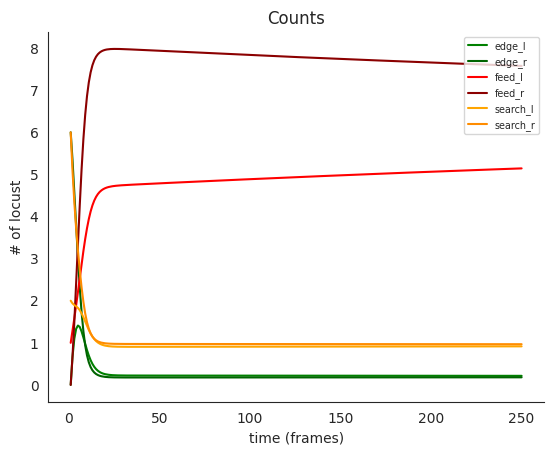

In [13]:
start_time = torch.tensor(start).float()
end_time = torch.tensor(end + 1).float()
step_size = 1
logging_times = torch.arange(start_time, end_time, step_size)


true_wander = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
true_attraction = torch.tensor([0.01, 0.01, 0.02, 0.02, 0.06, 0.1, 0.01, 0.01, 0.01])


locust_true = LocustDynamics(true_attraction, true_wander)


with TorchDiffEq(), LogTrajectory(logging_times) as lt:
    simulate(locust_true, init_state, start_time, end_time)

locust_true_traj = lt.trajectory


plot_trajectories(locust_true_traj, logging_times, window_size=0)

In [14]:
for _, tensor in locust_true_traj.items():
    assert torch.all(tensor >= 0)
    # locust_true_traj[key] = torch.clamp(tensor, min=0)

with pyro.poutine.trace() as tr:
    locust_noisy_model(locust_true_traj)

keys = ["edge_l", "edge_r", "search_l", "search_r", "feed_l", "feed_r"]
observed_keys = [f"{key}_obs" for key in keys]

synthetic_data = dict(**{k: tr.trace.nodes[k]["value"] for k in observed_keys})

assert count_data.keys() == synthetic_data.keys()

assert (
    count_data["edge_l_obs"].shape == synthetic_data["edge_l_obs"].shape
), f"count: {count_data['edge_l_obs'].shape}, synthetic: {synthetic_data['edge_l_obs'].shape}"

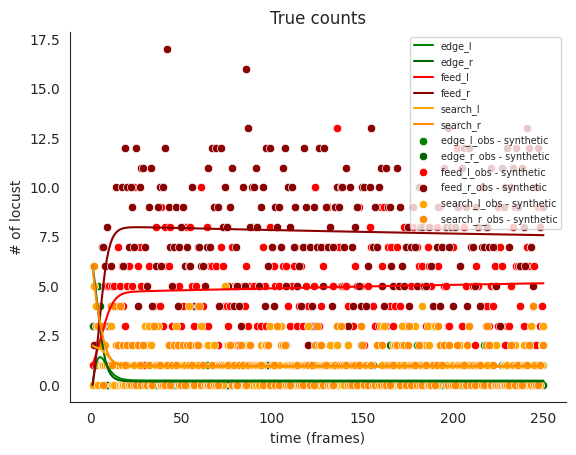

In [15]:
plot_trajectories(
    locust_true_traj,
    times,
    window_size=0,
    title="True counts",
    scatter_data=synthetic_data,
    scatter_data_type="synthetic",
)

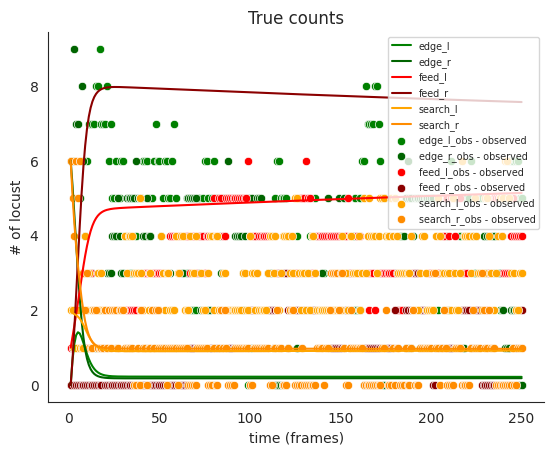

In [16]:
plot_trajectories(
    locust_true_traj,
    times,
    window_size=0,
    title="True counts",
    scatter_data=count_data,
    scatter_data_type="observed",
)

In [38]:
def bayesian_locust(base_model=LocustDynamics) -> Dynamics[torch.Tensor]:
    with pyro.plate("attr", size=9):
        attraction = pyro.sample("attraction", dist.Uniform(0, 1))
    with pyro.plate("wond", size=6):
        wander = pyro.sample("wander", dist.Uniform(0, 1))

    locust_model = base_model(attraction, wander)
    return locust_model


def simulated_bayesian_locust(
    init_state, start_time, logging_times, base_model=LocustDynamics
) -> State[torch.Tensor]:
    locust_model = bayesian_locust(base_model)
    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True) as lt:
        simulate(locust_model, init_state, start_time, logging_times[-1])
    return lt.trajectory

In [39]:
def get_locust_prior_samples_synthetic():
    prior_predictive = Predictive(simulated_bayesian_locust, num_samples=num_samples)
    locust_prior_samples = prior_predictive(init_state, start_time, logging_times)
    return locust_prior_samples


locust_prior_samples = progress_saver(
    name="locust_prior_samples_synthetic",
    subfolder="foraging/locust/ds",
    properties=[num_samples],
    property_names=["num_samples"],
    code_f=get_locust_prior_samples_synthetic,
)

/home/rafal/s78projects/collaborative-intelligence/data/foraging/locust/ds/locust_prior_samples_synthetic_num_samples_500.pkl
path missing, executing code


In [32]:
def locust_uncertainty_plot(
    time, state_pred, ylabel, color, ax, mean_label="posterior mean"
):
    sns.lineplot(
        x=time,
        y=state_pred.mean(dim=0).squeeze().tolist(),
        color=color,
        label=mean_label,
        ax=ax,
    )
    # 95% Credible Interval
    ax.fill_between(
        time,
        torch.quantile(state_pred, 0.025, dim=0).squeeze(),
        torch.quantile(state_pred, 0.975, dim=0).squeeze(),
        alpha=0.2,
        color=color,
        label="95% credible interval",
    )

    ax.set_xlabel("time")
    ax.set_ylabel(ylabel)


def intervention_uncertainty_plot(time_period, intervention, color, ax):
    sns.lineplot(
        x=time_period,
        y=intervention.mean(dim=0).squeeze().tolist(),
        color="grey",
        label="intervened posterior prediction",
        ax=ax,
    )


def locust_data_plot(time, data, data_label, ax):
    sns.lineplot(x=time, y=data, color="black", ax=ax, linestyle="--", label=data_label)


def locust_test_plot(test_start_time, test_end_time, ax):
    ax.axvline(
        test_start_time, color="black", linestyle=":", label="measurement period"
    )
    ax.axvline(test_end_time, color="black", linestyle=":")


def locust_plot(
    time_period,
    state_pred,
    data,
    ylabel,
    color,
    data_label,
    ax,
    legend=False,
    test_plot=True,
    test_start_time=start_time,
    test_end_time=start_time,
    mean_label="posterior mean",
    xlim=None,
    intervention=None,
):
    locust_uncertainty_plot(
        time_period, state_pred, ylabel, color, ax, mean_label=mean_label
    )
    locust_data_plot(time_period, data, data_label, ax)

    if intervention is not None:
        intervention_uncertainty_plot(time_period, intervention, color, ax)

    if test_plot:
        locust_test_plot(test_start_time, test_end_time, ax)
    if legend:
        ax.legend()
    else:
        ax.legend().remove()
    if xlim is not None:
        ax.set_xlim(0, xlim)
    sns.despine()

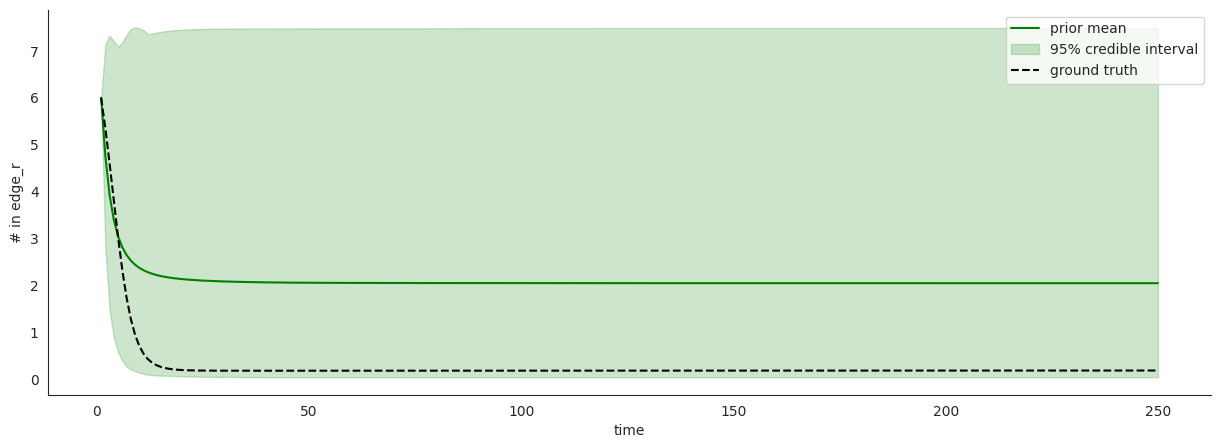

In [33]:
state = "edge_r"
color = "green"

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

locust_plot(
    logging_times,
    locust_prior_samples[state],
    locust_true_traj[state],
    f"# in {state}",
    color,
    "ground truth",
    ax,
    legend=True,
    test_plot=False,
    mean_label="prior mean",
)

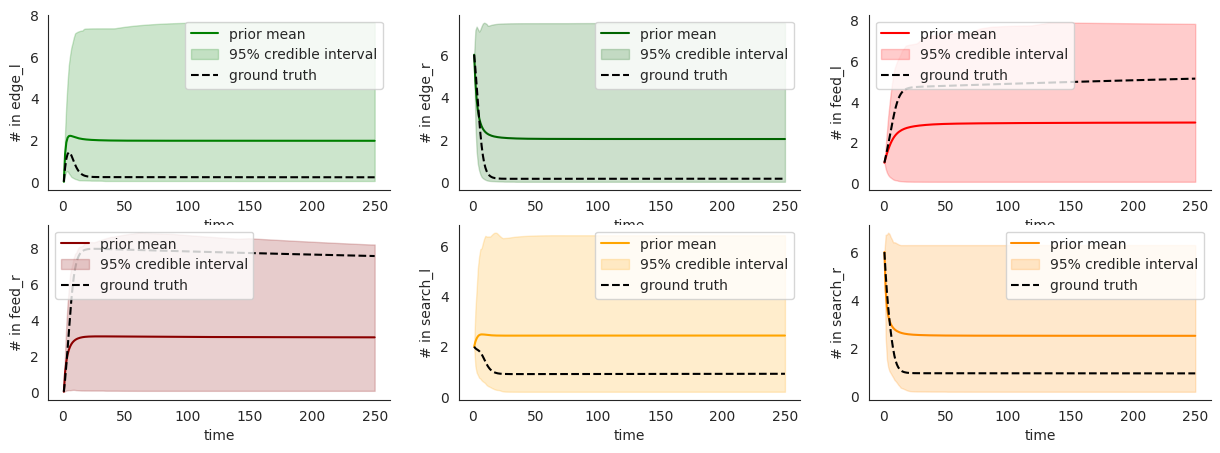

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))

ax = ax.flatten()

for i, state, color in zip(
    range(6),
    ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"],
    ["green", "darkgreen", "red", "darkred", "orange", "darkorange"],
):
    locust_plot(
        logging_times,
        locust_prior_samples[state],
        locust_true_traj[state],
        f"# in {state}",
        color,
        "ground truth",
        ax[i],
        legend=True,
        test_plot=False,
        mean_label="prior mean",
    )

In [24]:
def conditioned_locust(
    obs_times, data, init_state, start_time, base_model=LocustDynamics
) -> None:
    sir = bayesian_locust(base_model)
    obs = condition(data=data)(locust_noisy_model)
    with TorchDiffEq(), StaticBatchObservation(obs_times, observation=obs):
        simulate(sir, init_state, start_time, obs_times[-1])


def run_svi_inference(
    model,
    num_steps=num_steps,
    verbose=True,
    lr=0.03,
    vi_family=AutoMultivariateNormal,
    guide=None,
    **model_kwargs,
):
    losses = []
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, num_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        losses.append(loss.item())
        adam.step()
        if (step % 2 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))

    return guide

In [25]:
def get_locust_guide_synthetic():
    locust_guide = run_svi_inference(
        conditioned_locust,
        num_steps=num_steps,
        obs_times=logging_times,
        data=synthetic_data,
        init_state=init_state,
        start_time=start_time,
    )
    return locust_guide


locust_guide = progress_saver(
    name="locust_guide_synthetic",
    subfolder="foraging/locust/ds",
    properties=[num_steps],
    property_names=["num_steps"],
    code_f=get_locust_guide_synthetic,
)

/home/rafal/s78projects/collaborative-intelligence/data/foraging/locust/ds/locust_guide_synthetic_num_steps_100.pkl
path missing, executing code
[iteration 0001] loss: 3635.1457
[iteration 0002] loss: 3109.7936
[iteration 0004] loss: 3088.4371
[iteration 0006] loss: 3009.9396
[iteration 0008] loss: 3116.8138
[iteration 0010] loss: 2699.1646
[iteration 0012] loss: 2811.1240
[iteration 0014] loss: 2328.0605
[iteration 0016] loss: 2290.8946
[iteration 0018] loss: 2362.3044
[iteration 0020] loss: 2283.3866
[iteration 0022] loss: 2259.2114
[iteration 0024] loss: 2317.6831
[iteration 0026] loss: 2224.7249
[iteration 0028] loss: 2202.5476
[iteration 0030] loss: 2175.3807
[iteration 0032] loss: 2171.3040
[iteration 0034] loss: 2151.9770
[iteration 0036] loss: 2181.8578
[iteration 0038] loss: 2164.0607
[iteration 0040] loss: 2153.9040
[iteration 0042] loss: 2155.4614
[iteration 0044] loss: 2148.2482
[iteration 0046] loss: 2150.5414
[iteration 0048] loss: 2160.6765
[iteration 0050] loss: 2145.27

In [35]:
def get_locust_posterior_samples_synthetic():
    locust_predictive = Predictive(
        simulated_bayesian_locust, guide=locust_guide, num_samples=num_samples
    )
    locust_posterior_samples = locust_predictive(init_state, start_time, logging_times)
    return locust_posterior_samples


locust_posterior_samples = progress_saver(
    name="locust_posterior_samples_synthetic",
    subfolder="foraging/locust/ds",
    properties=[num_samples],
    property_names=["num_samples"],
    code_f=get_locust_posterior_samples_synthetic,
)

/home/rafal/s78projects/collaborative-intelligence/data/foraging/locust/ds/locust_posterior_samples_synthetic_num_samples_500.pkl
path missing, executing code


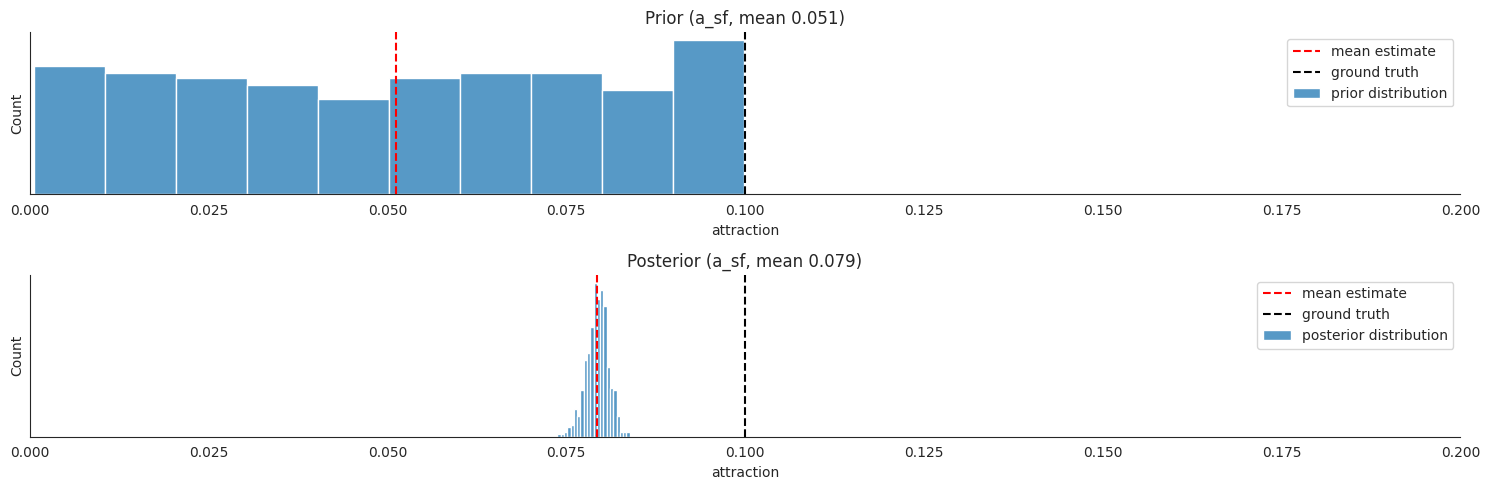

In [37]:
def plot_estimates(
    prior_samples, posterior_samples, group, which_coeff, ground_truth=False, xlim=0.5
):
    coef_names = {
        "wander": ["w_ee", "w_es", "w_se", "w_sf", "w_fs", "w_ss"],
        "attraction": [
            "a_eler",
            "a_erel",
            "a_es",
            "a_se",
            "a_ef",
            "a_sf",
            "a_fs",
            "a_slsr",
            "a_srsl",
        ],
    }

    fig, ax = plt.subplots(2, 1, figsize=(15, 5))
    i = which_coeff

    sns.histplot(
        prior_samples[group][:, i], label="prior distribution", ax=ax[0], kde=False
    )

    ax[0].axvline(
        prior_samples[group][:, i].mean(),
        color="red",
        label="mean estimate",
        linestyle="--",
    )

    if ground_truth:
        if group == "attraction":
            ax[0].axvline(
                true_attraction[i], color="black", label="ground truth", linestyle="--"
            )
        if group == "wander":
            ax[0].axvline(true_wander[i], color="black", linestyle="--")

    ax[0].set_title(
        f"Prior ({coef_names[group][i]}, mean {round(prior_samples[group][:, i].mean().item(),3)})"
    )
    sns.despine(ax=ax[0])
    ax[0].set_yticks([])
    ax[0].legend(loc="upper right")
    ax[0].set_xlabel(group)
    ax[0].set_xlim([0, xlim])

    sns.histplot(
        posterior_samples[group][:, i],
        label="posterior distribution",
        ax=ax[1],
        kde=False,
    )

    ax[1].axvline(
        posterior_samples[group][:, i].mean(),
        color="red",
        label="mean estimate",
        linestyle="--",
    )

    if ground_truth:
        if group == "attraction":
            ax[1].axvline(
                true_attraction[i], color="black", label="ground truth", linestyle="--"
            )
        if group == "wander":
            ax[1].axvline(true_wander[i], color="black", linestyle="--")

    ax[1].set_title(
        f"Posterior ({coef_names[group][i]}, mean {round(posterior_samples[group][:, i].mean().item(),3)})"
    )
    sns.despine(ax=ax[1])
    ax[1].set_yticks([])
    ax[1].legend(loc="upper right")
    ax[1].set_xlabel(group)
    ax[1].set_xlim([0, xlim])

    plt.tight_layout()
    plt.show()


plot_estimates(
    locust_prior_samples,
    locust_posterior_samples,
    "attraction",
    5,
    ground_truth=True,
    xlim=0.2,
)

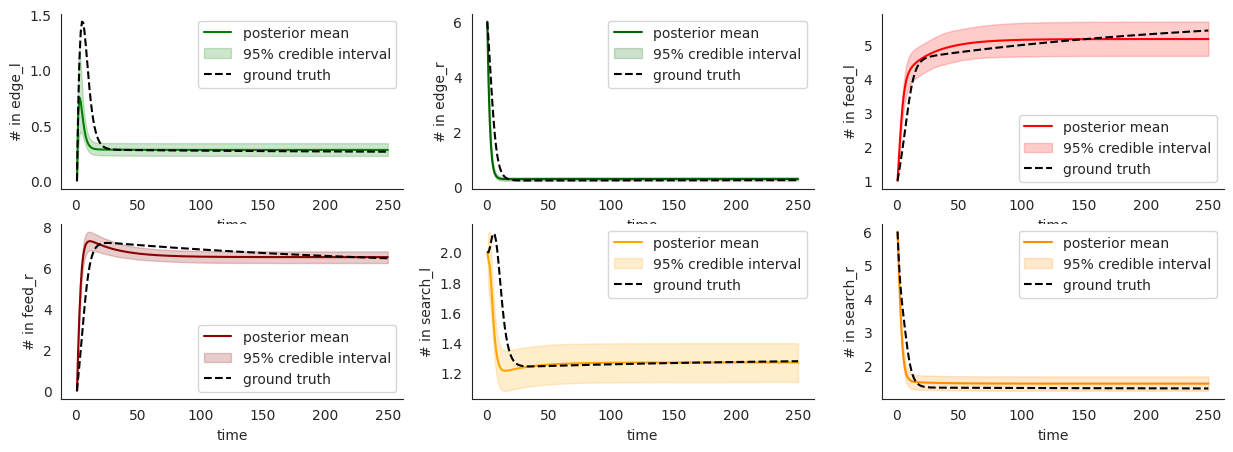

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))

ax = ax.flatten()

for i, state, color in zip(
    range(6),
    ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"],
    ["green", "darkgreen", "red", "darkred", "orange", "darkorange"],
):
    locust_plot(
        logging_times,
        locust_posterior_samples[state],
        locust_true_traj[state],
        f"# in {state}",
        color,
        "ground truth",
        ax[i],
        legend=True,
        test_plot=False,
        mean_label="posterior mean",
    )

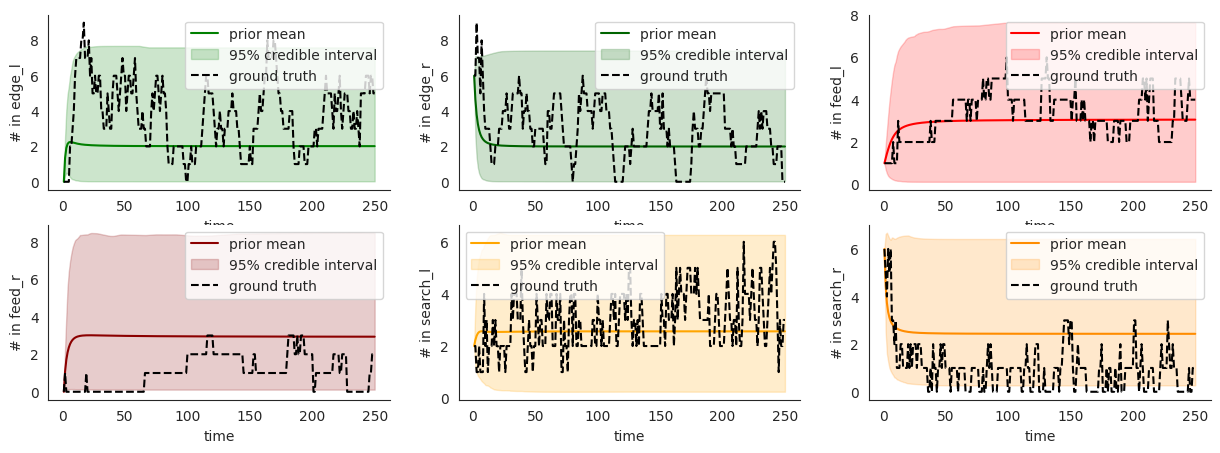

In [27]:
def prior_real_locust_check():
    fig, ax = plt.subplots(2, 3, figsize=(15, 5))

    ax = ax.flatten()

    for i, state, color in zip(
        range(6),
        ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"],
        ["green", "darkgreen", "red", "darkred", "orange", "darkorange"],
    ):
        locust_plot(
            logging_times,
            locust_prior_samples[state],
            count_data[f"{state}_obs"],
            f"# in {state}",
            color,
            "ground truth",
            ax[i],
            legend=True,
            test_plot=False,
            mean_label="prior mean",
        )


prior_real_locust_check()

/home/rafal/s78projects/collaborative-intelligence/data/foraging/locust/ds/locust_prior_samples_real_num_samples_500.pkl
path found, loading data


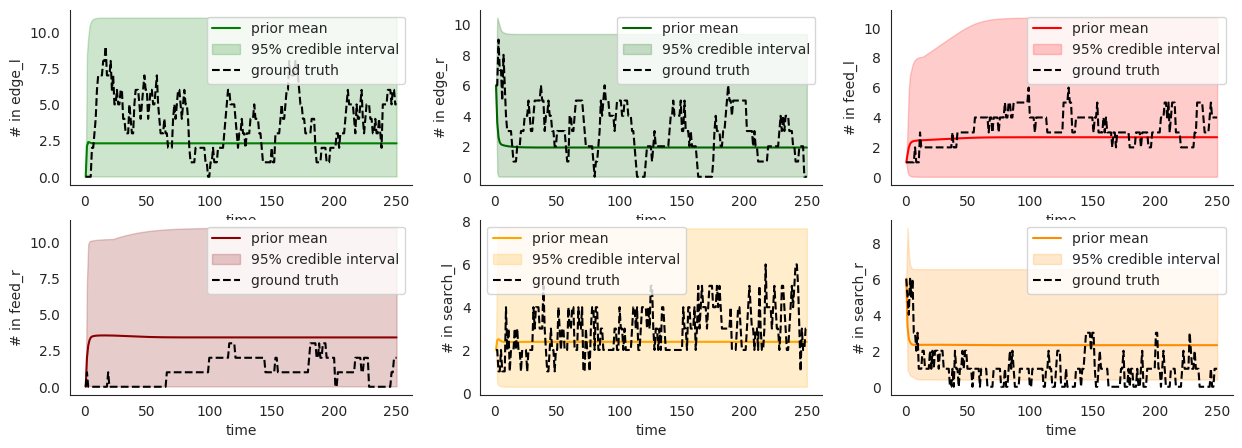

In [28]:
def bayesian_locust(base_model=LocustDynamics) -> Dynamics[torch.Tensor]:
    with pyro.plate("attr", size=8):
        attraction = pyro.sample("attraction", dist.Uniform(0, 1))
    with pyro.plate("wond", size=6):
        wander = pyro.sample("wander", dist.Uniform(0, 1))

    locust_model = base_model(attraction, wander)
    return locust_model


def get_locust_prior_samples_real():
    prior_predictive = Predictive(simulated_bayesian_locust, num_samples=20)
    locust_prior_samples = prior_predictive(init_state, start_time, logging_times)
    return locust_prior_samples


locust_prior_samples = progress_saver(
    name="locust_prior_samples_real",
    subfolder="foraging/locust/ds",
    properties=[num_samples],
    property_names=["num_samples"],
    code_f=get_locust_prior_samples_real,
)

prior_real_locust_check()

In [29]:
def conditioned_locust(
    obs_times, data, init_state, start_time, base_model=LocustDynamics
) -> None:
    sir = bayesian_locust(base_model)
    obs = condition(data=data)(locust_noisy_model)
    with TorchDiffEq(), StaticBatchObservation(obs_times, observation=obs):
        simulate(sir, init_state, start_time, obs_times[-1])

In [30]:
def get_guide_real():
    real_locust_guide = run_svi_inference(
        conditioned_locust,
        num_steps=num_steps,
        obs_times=logging_times,
        data=count_data,
        init_state=init_state,
        start_time=start_time,
    )
    return real_locust_guide


real_locust_guide = progress_saver(
    name="real_locust_guide",
    subfolder="foraging/locust/ds",
    properties=[num_steps],
    property_names=["num_steps"],
    code_f=get_guide_real,
)

/home/rafal/s78projects/collaborative-intelligence/data/foraging/locust/ds/real_locust_guide_num_steps_100.pkl
path found, loading data


In [31]:
def get_locust_posterior_samples_real():
    real_locust_predictive = Predictive(
        simulated_bayesian_locust, guide=real_locust_guide, num_samples=num_samples
    )
    real_locust_posterior_samples = real_locust_predictive(
        init_state, start_time, logging_times
    )
    return real_locust_posterior_samples


real_locust_posterior_samples = progress_saver(
    name="real_locust_posterior_samples",
    subfolder="foraging/locust/ds",
    properties=[num_samples],
    property_names=["num_samples"],
    code_f=get_locust_posterior_samples_real,
)

/home/rafal/s78projects/collaborative-intelligence/data/foraging/locust/ds/real_locust_posterior_samples_num_samples_500.pkl
path found, loading data


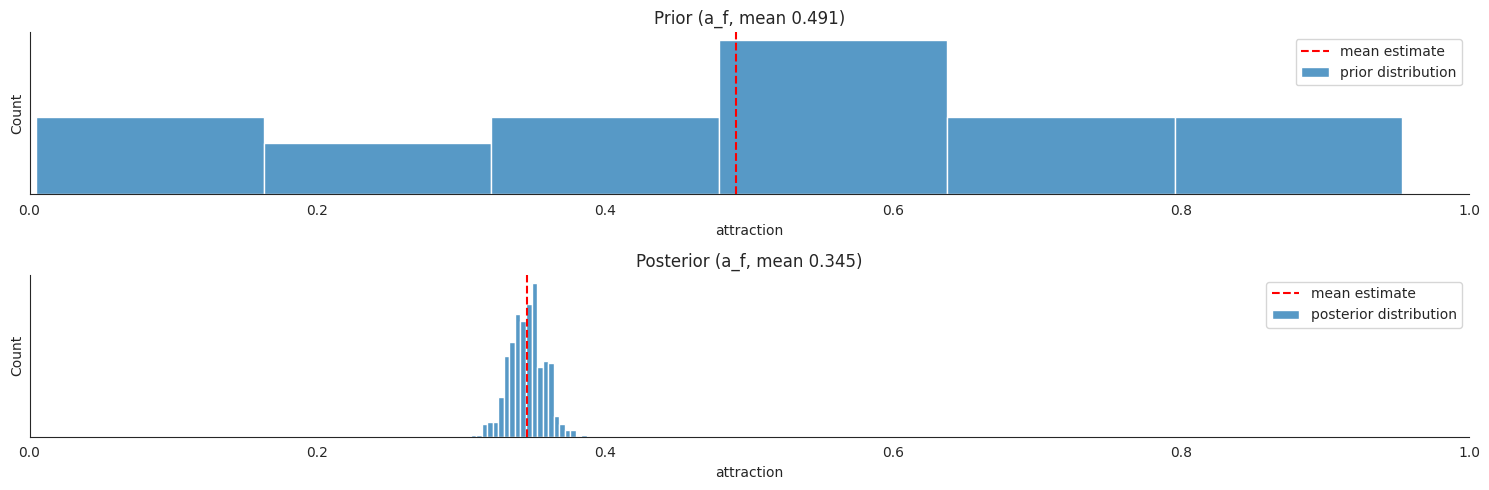

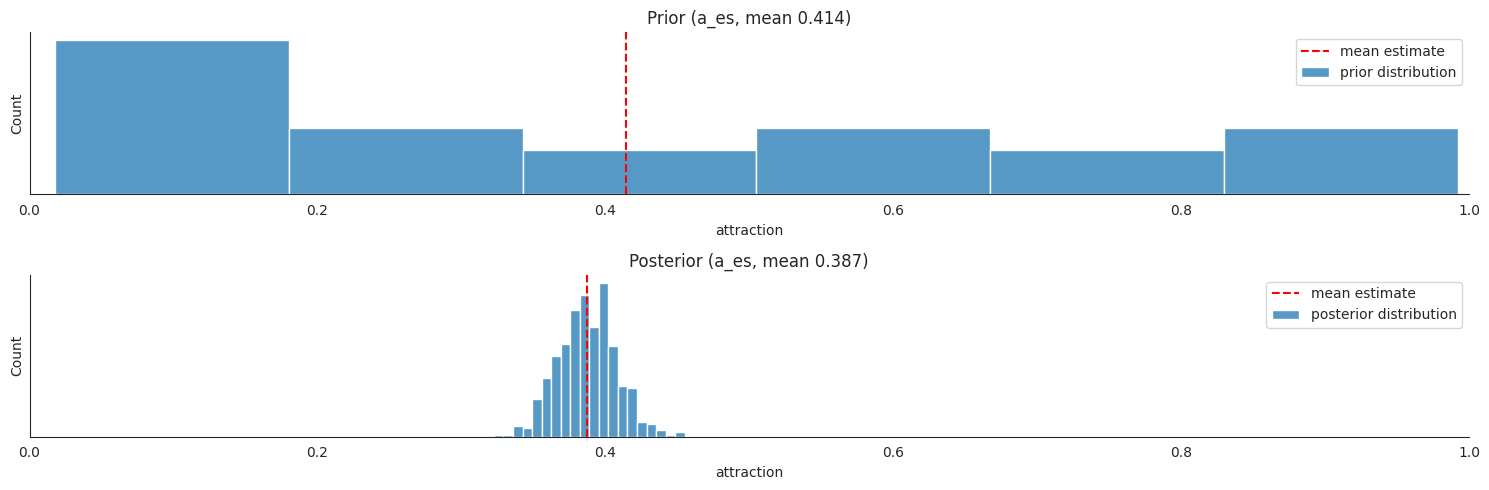

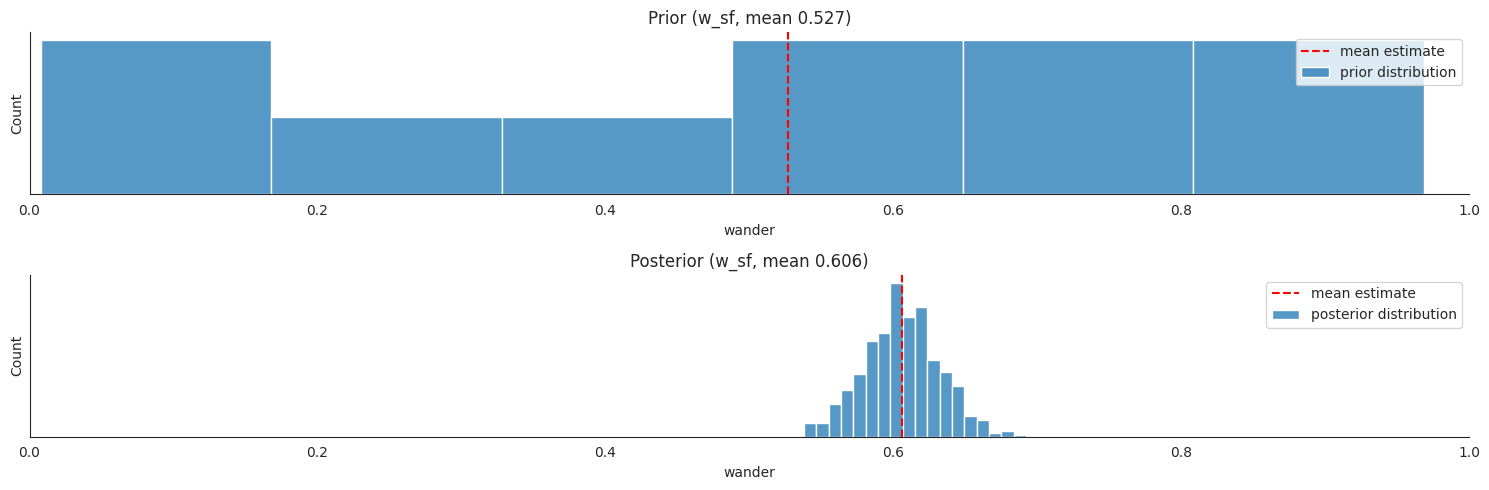

In [32]:
plot_estimates(
    locust_prior_samples,
    real_locust_posterior_samples,
    "attraction",
    4,
    ground_truth=False,
    xlim=1,
)


plot_estimates(
    locust_prior_samples,
    real_locust_posterior_samples,
    "attraction",
    2,
    ground_truth=False,
    xlim=1,
)


plot_estimates(
    locust_prior_samples,
    real_locust_posterior_samples,
    "wander",
    3,
    ground_truth=False,
    xlim=1,
)

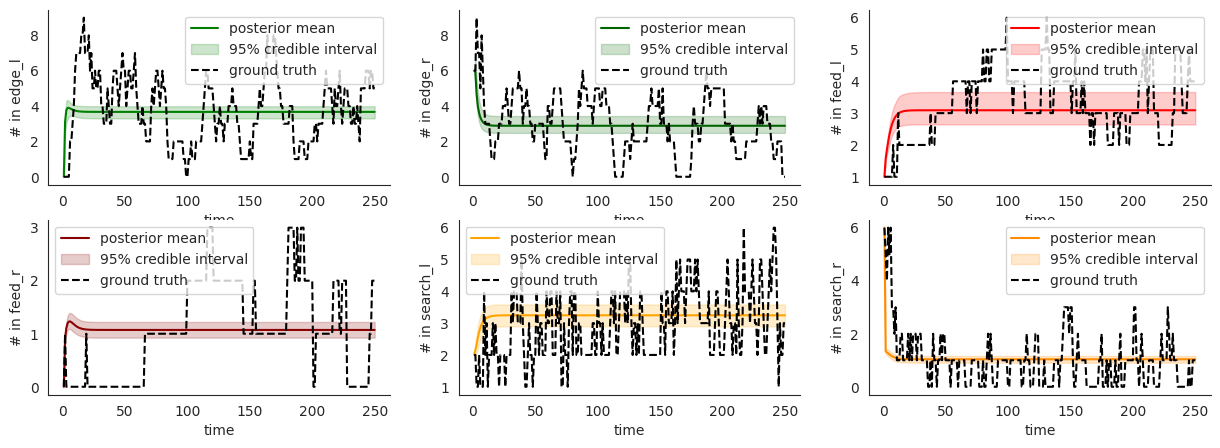

In [33]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))

ax = ax.flatten()

for i, state, color in zip(
    range(6),
    ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"],
    ["green", "darkgreen", "red", "darkred", "orange", "darkorange"],
):
    locust_plot(
        logging_times,
        real_locust_posterior_samples[state],
        count_data[f"{state}_obs"],
        f"# in {state}",
        color,
        "ground truth",
        ax[i],
        legend=True,
        test_plot=False,
        mean_label="posterior mean",
    )

In [34]:
def intervened_locust(
    intervention_starts,
    intervened_a_f,
    init_state,
    start_time,
    logging_times,
) -> State[torch.Tensor]:
    locust_model = bayesian_locust(base_model=LocustDynamics)
    with LogTrajectory(logging_times, is_traced=True) as lt_intervened:
        with TorchDiffEq():
            with StaticIntervention(
                time=intervention_starts, intervention=dict(a_f=intervened_a_f)
            ):
                simulate(locust_model, init_state, start_time, logging_times[-1])

    return lt_intervened.trajectory

In [35]:
intervention_starts = 1
intervened_a_f = 0.0

intervened_locust_predictive = Predictive(
    intervened_locust, guide=real_locust_guide, num_samples=10
)
intervened_locust_posterior_samples = intervened_locust_predictive(
    intervention_starts,
    intervened_a_f,
    init_state,
    start_time,
    logging_times,
)

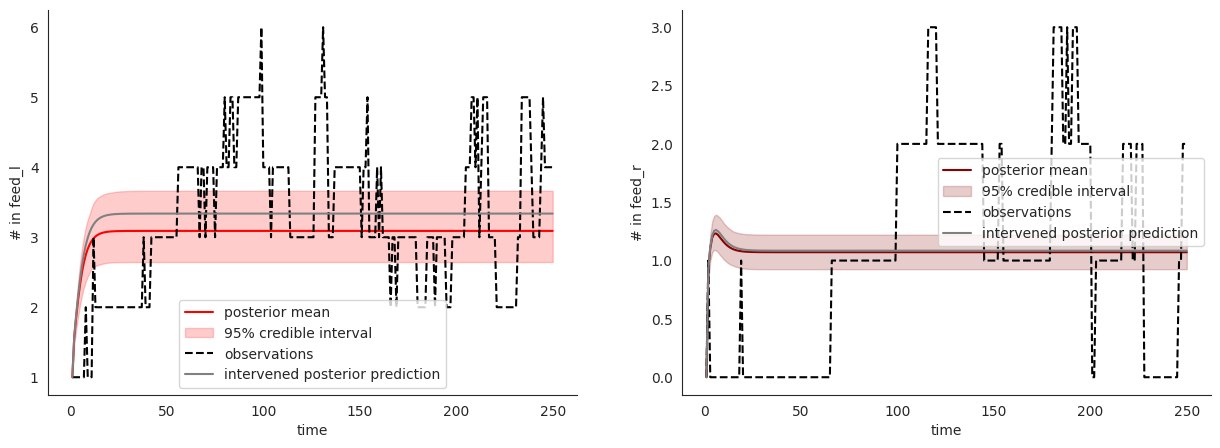

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax = ax.flatten()

for i, state, color in zip(
    range(2),
    ["feed_l", "feed_r"],
    ["red", "darkred"],
):
    locust_plot(
        logging_times,
        real_locust_posterior_samples[state],
        count_data[f"{state}_obs"],
        f"# in {state}",
        color,
        "observations",
        ax[i],
        legend=True,
        test_plot=False,
        mean_label="posterior mean",
        intervention=intervened_locust_posterior_samples[state],
    )

In [34]:
notebook_ends = time.time()
print(
    "notebook took",
    notebook_ends - notebook_starts,
    "seconds, that is ",
    (notebook_ends - notebook_starts) / 60,
    "minutes to run",
)

notebook took 29.969359159469604 seconds, that is  0.4994893193244934 minutes to run


In [35]:
# print(count_data.keys())
# print(real_locust_posterior_samples.keys())

means = {}
mean_preds = {}
tss = {}
rss = {}
rsquared = {}
for key in ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"]:
    means[f"{key}_obs"] = torch.mean(count_data[f"{key}_obs"])
    tss[key] = torch.sum((count_data[f"{key}_obs"] - means[f"{key}_obs"]) ** 2)
    mean_preds[key] = real_locust_posterior_samples[key].mean(dim=0)
    rss[key] = torch.sum((count_data[f"{key}_obs"] - mean_preds[key]) ** 2)
    rsquared[key] = 1 - (rss[key] / tss[key])

display(rsquared)

# plt.scatter(count_data["edge_l_obs"], mean_preds["edge_l"])
# plt.show()

# mean_sim_outcome = simulated_outcome.mean(0).detach().cpu().numpy()

# observed_mean = torch.mean(how_far)

# tss = torch.sum((how_far - observed_mean) ** 2)
# rss = torch.sum((how_far - mean_sim_outcome) ** 2)

# r_squared = 1 - (rss / tss)

{'edge_l': tensor(0.0098, dtype=torch.float64),
 'edge_r': tensor(0.0765, dtype=torch.float64),
 'feed_l': tensor(0.0543, dtype=torch.float64),
 'feed_r': tensor(-0.0090, dtype=torch.float64),
 'search_l': tensor(-0.0445, dtype=torch.float64),
 'search_r': tensor(0.1223, dtype=torch.float64)}